## Setup, Loading Data and CDFs

In [ ]:
DATA_NAME = 'spaceNet-full' 
TRANSFORM = 'wavelet-horizVert'
CHANNEL = 'blue'

In [2]:
path_list = DATA_NAME.split("-") + TRANSFORM.split("-")
if CHANNEL:
    path_list.append(CHANNEL)
print(f"Name the notebook:\n{'_'.join(path_list[::-1])}.ipynb")
FULL_DATA_NAME='-'.join(path_list)

Name the notebook:
blue_wavelet_full_spaceNet.ipynb


In [3]:
import git
from pathlib import Path
import os

ROOT_DIR = Path(git.Repo('.', search_parent_directories=True).working_tree_dir)
CWD = os.path.join(ROOT_DIR, "results", "case-studies", *path_list)

assert CWD == os.getcwd()
Path(os.path.join(CWD, "CSVs")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "plots")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "cache")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "groupCDFs")).mkdir(exist_ok=True)

GROUP = 'layer' if TRANSFORM.split("-")[0] == 'wavelet' else ('band' if TRANSFORM.split("-")[0] == 'fourier' else 'error')
RERUN = False
SKIP_OPTIMIZE_STEP = True
CWD

'/Users/michaelmurphy/Documents/GitHub/hierarchical-bayesian-model-validation/results/case-studies/spaceNet/full/wavelet/blue'

In [4]:
os.chdir(os.path.join(ROOT_DIR, "utilities"))
from testing import * # If MATLAB is not installed, open utilities and set to False
from plotting import *
os.chdir(CWD)
np.random.seed(0)

In [5]:
group_data_map = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data", f'{FULL_DATA_NAME}.pickle'))
group_total_samples = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data", f'{FULL_DATA_NAME}-size.pickle'))

In [6]:
if TRANSFORM == 'fourier':
    GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)[::3]
elif TRANSFORM == 'wavelet':
    GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)

cdfs_dir = os.path.join(ROOT_DIR, "results", "CDFs")
cdfs_list = sorted([os.path.join(cdfs_dir, i) for i in os.listdir(cdfs_dir)])
all_cdfs = combine_pickles(cdfs_list[0])
for cdf_dir in cdfs_list[:5]: # TODO For quick testing purposes. Currently excluding 20000 CDFs. Use cdfs_list[5:6] to access CDFs/_test
    all_cdfs = all_cdfs | combine_pickles(cdf_dir)
    
# group_data_map = {g : group_data_map[g][::100] for g in GROUPS} # TODO For quick testing purposes
group_total_samples

{2: 27208,
 3: 108832,
 4: 333298,
 5: 1149538,
 6: 4251250,
 7: 17005000,
 8: 68020000,
 9: 272080000}

Running 7880 CDFs


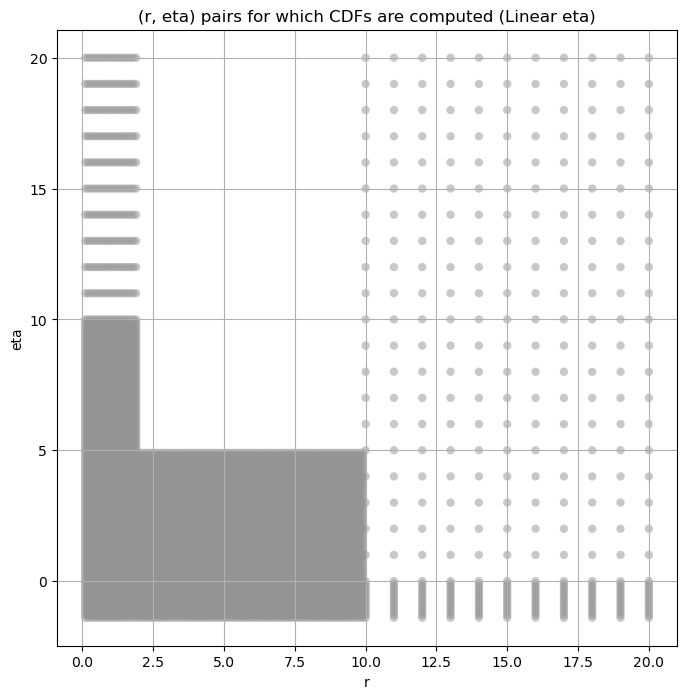

,"(r,eta),cdf",r,eta,cdf,variance,kurtosis
0,"((0.1, -1.4), <scipy.interpolate._fitpack2.Int...",0.1,-1.4,<scipy.interpolate._fitpack2.InterpolatedUniva...,3.628800e+06,554265.000000
1,"((0.1, -1.3), <scipy.interpolate._fitpack2.Int...",0.1,-1.3,<scipy.interpolate._fitpack2.InterpolatedUniva...,3.991680e+07,96192.272727
2,"((0.1, -1.2), <scipy.interpolate._fitpack2.Int...",0.1,-1.2,<scipy.interpolate._fitpack2.InterpolatedUniva...,2.395008e+08,29390.000000
3,"((0.1, -1.1), <scipy.interpolate._fitpack2.Int...",0.1,-1.1,<scipy.interpolate._fitpack2.InterpolatedUniva...,1.037837e+09,11997.692308
4,"((0.1, -1.0), <scipy.interpolate._fitpack2.Int...",0.1,-1.0,<scipy.interpolate._fitpack2.InterpolatedUniva...,3.632429e+09,5874.890110


In [7]:
warnings.filterwarnings('ignore', category=RuntimeWarning)

all_cdfs_df = create_kurt_var_ksstat_df(all_cdfs)
all_cdfs_df = all_cdfs_df[(np.round(all_cdfs_df['r'], 1) == all_cdfs_df['r']) & (np.round(all_cdfs_df['eta'], 1) == all_cdfs_df['eta'])]
all_cdfs_df = all_cdfs_df.reset_index().drop("index", axis = 1)
all_cdfs = {x[0] : x[1] for x in all_cdfs_df["(r,eta),cdf"]}
                                             
var_values_dict = dict()
kurt_values_dict = dict()
master_df = pd.DataFrame(columns=[GROUP]).set_index(GROUP)
temp_cdf = all_cdfs_df
print(f"Running {all_cdfs_df.shape[0]} CDFs")
create_scatter_plot(all_cdfs_df);
all_cdfs_df.head()

## Bootstrapping the Variance and Kurtosis

In [8]:
n_bootstrap = int(1e5) # TODO For quick testing purposes
bootstrap_size = int(1e4) # TODO For quick testing purposes
ci = 0.99

In [9]:
bootstrap_path = Path(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))
master_df_var_kurt_path = Path(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))

if RERUN or not master_df_var_kurt_path.exists(): # TODO For quick testing purposes
    for group in GROUPS:
        print(f'{GROUP.capitalize()} {group}')
        obs_var, var_lower, var_upper, var_values_dict[group] = bootstrap_metric(group_data_map[group], 
                                                                                n_bootstrap=n_bootstrap, 
                                                                                bootstrap_size=min(group_data_map[group].size, bootstrap_size), 
                                                                                metric= np.var, 
                                                                                ci=ci)
        obs_kurt, kurt_lower, kurt_upper, kurt_values_dict[group] = bootstrap_metric(group_data_map[group], 
                                                                                    n_bootstrap=n_bootstrap, 
                                                                                    bootstrap_size=min(group_data_map[group].size, bootstrap_size), 
                                                                                    metric= stats.kurtosis, ci=ci)  
        master_df.loc[group, 'obs_var'], master_df.loc[group, 'var_lower'], master_df.loc[group, 'var_upper'] = obs_var, var_lower, var_upper
        master_df.loc[group, 'obs_kurt'], master_df.loc[group, 'kurt_lower'], master_df.loc[group, 'kurt_upper'] = obs_kurt, kurt_lower, kurt_upper
        master_df.loc[group, 'total_samples'] = group_total_samples[group]

    master_df.to_csv(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))

master_df = pd.read_csv(master_df_var_kurt_path, index_col=GROUP)
var_kurt_df = pd.read_csv(bootstrap_path, index_col=GROUP)
master_df

Layer 2


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 3


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 4


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 5


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 6


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 7


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 8


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 9


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

,obs_var,var_lower,var_upper,obs_kurt,kurt_lower,kurt_upper,total_samples
layer,,,,,,,
2,17099.951000,16011.873000,18266.027000,4.485870,2.916318,6.963518,27208.0
3,4439.328600,4054.799300,4889.549300,11.246322,5.995842,23.188679,108832.0
4,1375.095100,1259.372800,1507.274400,9.947575,6.166291,20.854307,333298.0
5,383.261080,347.357240,432.744660,15.710056,6.790803,61.522090,1149538.0
6,87.512500,79.347590,97.938730,14.396328,7.234616,41.982544,4251250.0
7,18.372583,16.360443,21.660446,26.511518,9.414252,122.701400,17005000.0
8,3.833611,3.316390,4.837249,51.002052,13.016896,233.355440,68020000.0
9,0.722777,0.589432,1.182955,243.846040,15.030614,913.274840,272080000.0


## Initial Grid Search and Hypothesis Test Plots

In [10]:
EXCLUDE_CUTOFFS = [0, 25, 50, 75, 100, 150, 200, 250, 300, 350, 500] # TODO For quick testing purposes
SCALE_CAP = 1e5

In [11]:
augmented_var_df_path = Path(os.path.join(CWD, "CSVs", "augmented_var_df.csv"))
augmented_var_df = var_kurt_df[['obs_var']].copy()
augmented_var_df
for val in EXCLUDE_CUTOFFS:
    temp_arr = []
    for group in GROUPS:
        if val != 0:
            temp_arr.append(np.var(group_data_map[group][val:-val]))
        else:
            temp_arr.append(np.var(group_data_map[group]))

    augmented_var_df[f"var_exclude_{val}"] = temp_arr
augmented_var_df

,obs_var,var_exclude_0,var_exclude_25,var_exclude_50,var_exclude_75,var_exclude_100,var_exclude_150,var_exclude_200,var_exclude_250,var_exclude_300,var_exclude_350,var_exclude_500
layer,,,,,,,,,,,,
2,17099.951000,17099.951172,16030.946289,15466.998047,15026.830078,14642.878906,13979.685547,13403.716797,12901.042969,12449.382812,12033.920898,10956.669922
3,4439.328600,4439.328613,4233.755859,4140.746094,4064.417236,4000.475830,3890.007324,3793.830566,3707.581055,3629.487061,3558.294922,3370.039062
4,1375.095100,1375.095093,1318.398682,1287.501709,1263.282959,1242.286987,1206.405640,1175.987793,1149.096069,1124.818481,1102.432617,1043.945801
5,383.261080,383.261078,363.919495,354.908386,347.653168,341.437073,331.056000,322.332825,314.621979,307.621460,301.190979,284.354614
6,87.512500,87.512497,83.097839,80.927231,79.221344,77.756241,75.284225,73.199028,71.365097,69.713623,68.203453,64.275719
7,18.372583,18.372583,17.207876,16.685886,16.273804,15.923417,15.334048,14.839373,14.406991,14.019738,13.667419,12.761007
8,3.833611,3.833611,3.504797,3.370999,3.267645,3.181046,3.037758,2.919637,2.817884,2.727952,2.647056,2.442562
9,0.722777,0.722777,0.621594,0.594202,0.573752,0.556946,0.529689,0.507625,0.488885,0.472483,0.457841,0.421251


####
Layer  2


  0%|          | 0/7880 [00:00<?, ?it/s]

Finding Minimum after computing 7880 CDFs
2 0 0.014666520158181484 17099.951


  0%|          | 0/7880 [00:00<?, ?it/s]

Finding Minimum after computing 7880 CDFs
2 25 0.014747012749471378 16030.946


  0%|          | 0/7880 [00:00<?, ?it/s]

Finding Minimum after computing 7880 CDFs
2 50 0.014783153068924693 15466.998
Number of samples: 27208, Without approximation : 27208.0


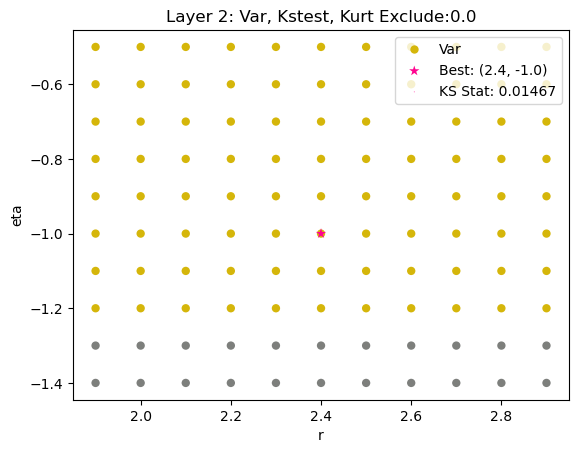

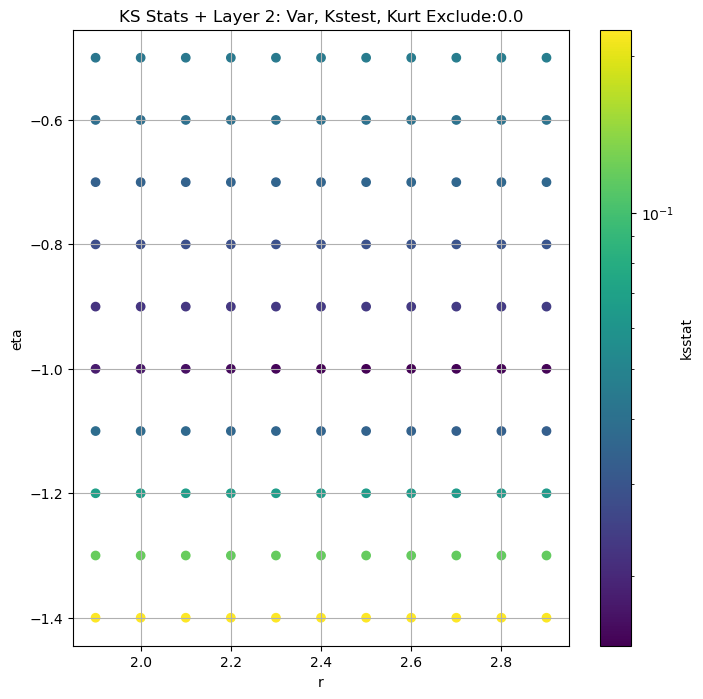

####
Layer  3


  0%|          | 0/7880 [00:00<?, ?it/s]

Finding Minimum after computing 7880 CDFs
3 0 0.13193999999999978 4439.3286


  0%|          | 0/7880 [00:00<?, ?it/s]

Finding Minimum after computing 7880 CDFs
3 25 0.13193999999999978 4233.756


  0%|          | 0/7880 [00:00<?, ?it/s]

Finding Minimum after computing 7880 CDFs
3 50 0.13193999999999978 4140.746
Number of samples: 100000, Without approximation : 108832.0


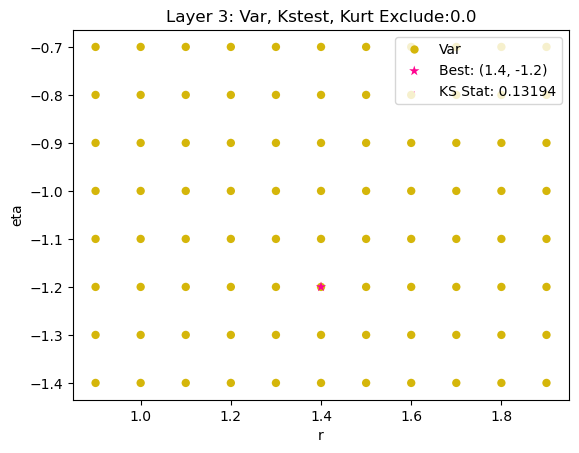

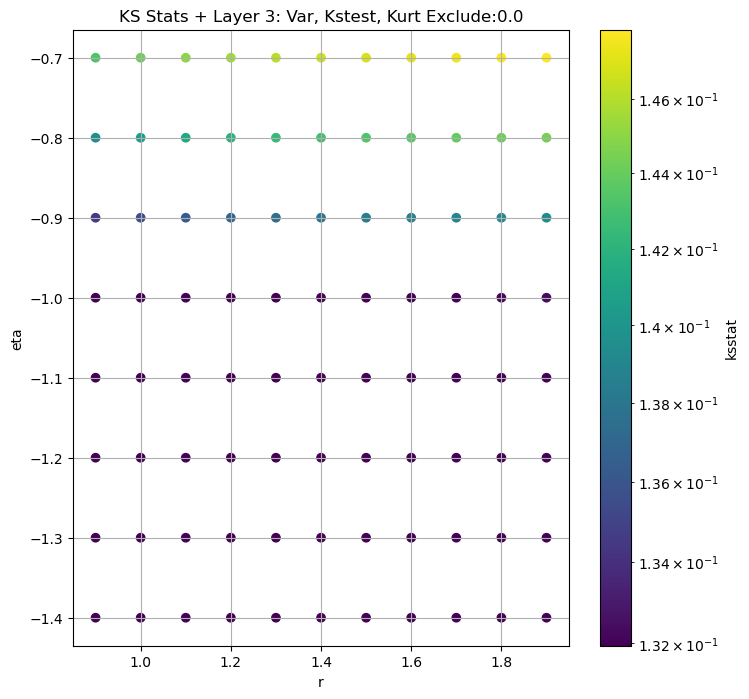

####
Layer  4


  0%|          | 0/7880 [00:00<?, ?it/s]

Finding Minimum after computing 7880 CDFs
4 0 0.0750099999999998 1375.0951


  0%|          | 0/7880 [00:00<?, ?it/s]

Finding Minimum after computing 7880 CDFs
4 25 0.0750099999999998 1318.3987


  0%|          | 0/7880 [00:00<?, ?it/s]

Finding Minimum after computing 7880 CDFs
4 50 0.0750099999999998 1287.5017
Number of samples: 100000, Without approximation : 333298.0


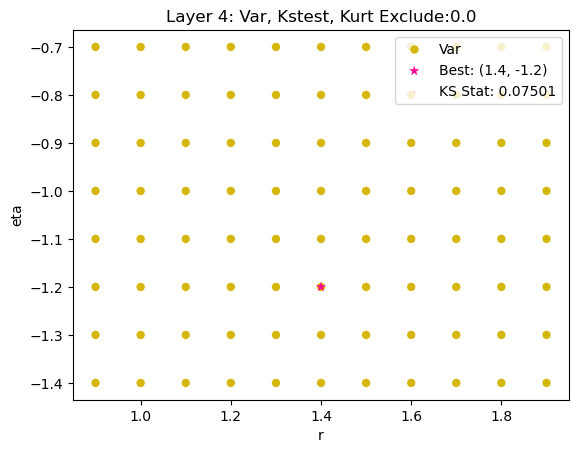

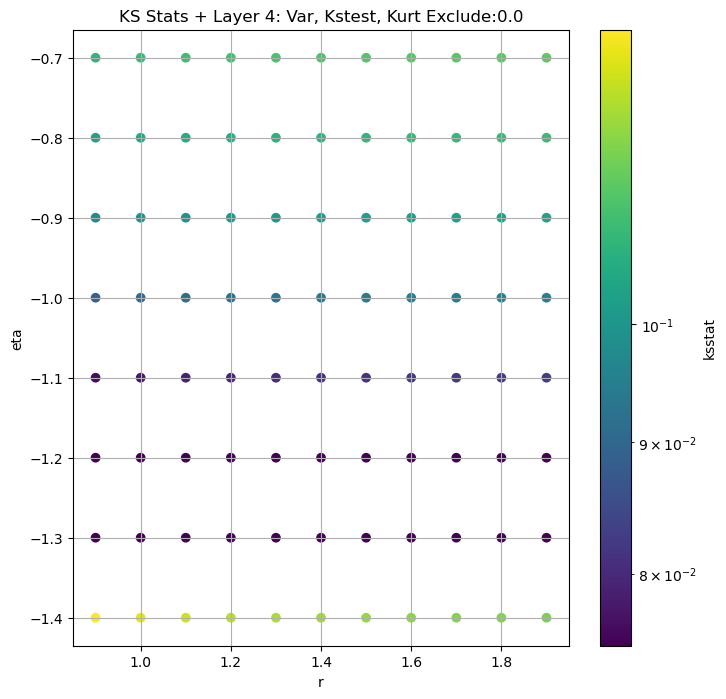

####
Layer  5


  0%|          | 0/7880 [00:00<?, ?it/s]

Finding Minimum after computing 7880 CDFs
5 0 0.039669999999999817 383.26108


  0%|          | 0/7880 [00:00<?, ?it/s]

Finding Minimum after computing 7880 CDFs
5 25 0.03966999999999976 363.9195


  0%|          | 0/7880 [00:00<?, ?it/s]

Finding Minimum after computing 7880 CDFs
5 50 0.03966999999999976 354.9084
Number of samples: 100000, Without approximation : 1149538.0


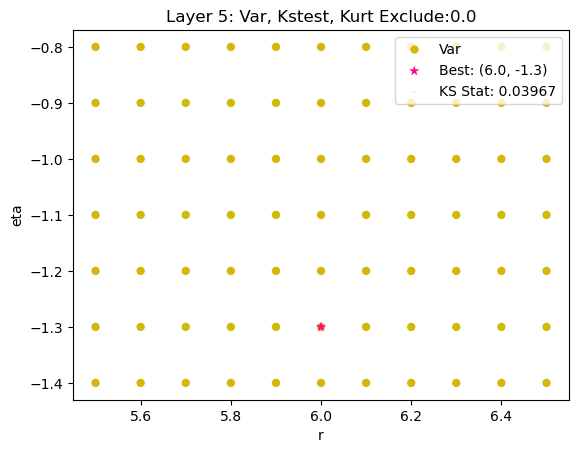

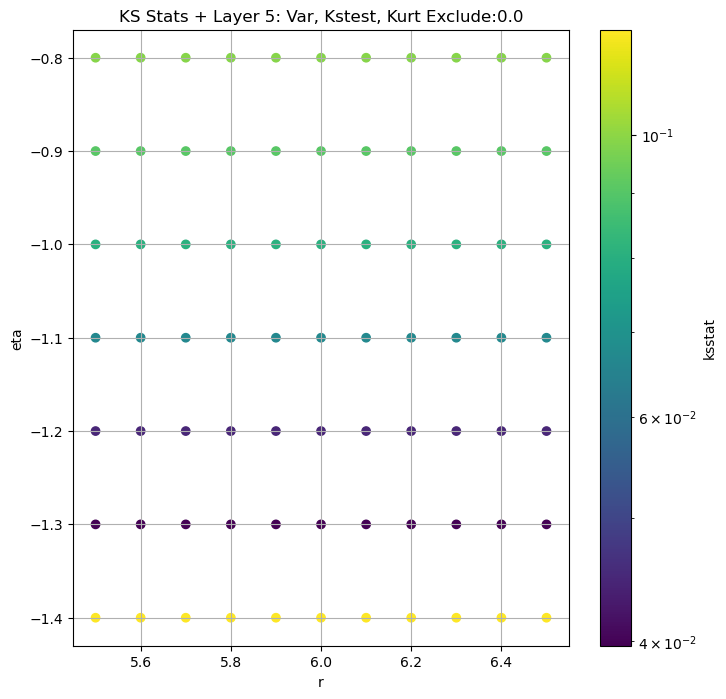

####
Layer  6


  0%|          | 0/7880 [00:00<?, ?it/s]

Finding Minimum after computing 7880 CDFs
6 0 0.013914606666053486 87.5125


  0%|          | 0/7880 [00:00<?, ?it/s]

Finding Minimum after computing 7880 CDFs
6 25 0.01395575423530615 83.09784


  0%|          | 0/7880 [00:00<?, ?it/s]

Finding Minimum after computing 7880 CDFs
6 50 0.013521995116856977 80.92723


  0%|          | 0/7880 [00:00<?, ?it/s]

Finding Minimum after computing 7880 CDFs
6 75 0.013894711355865397 79.221344
Number of samples: 100000, Without approximation : 4251250.0


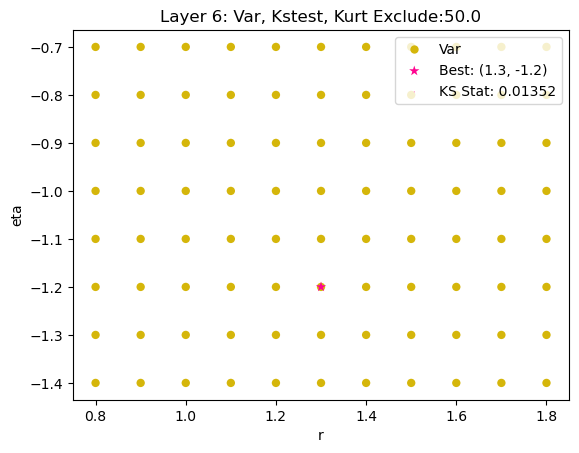

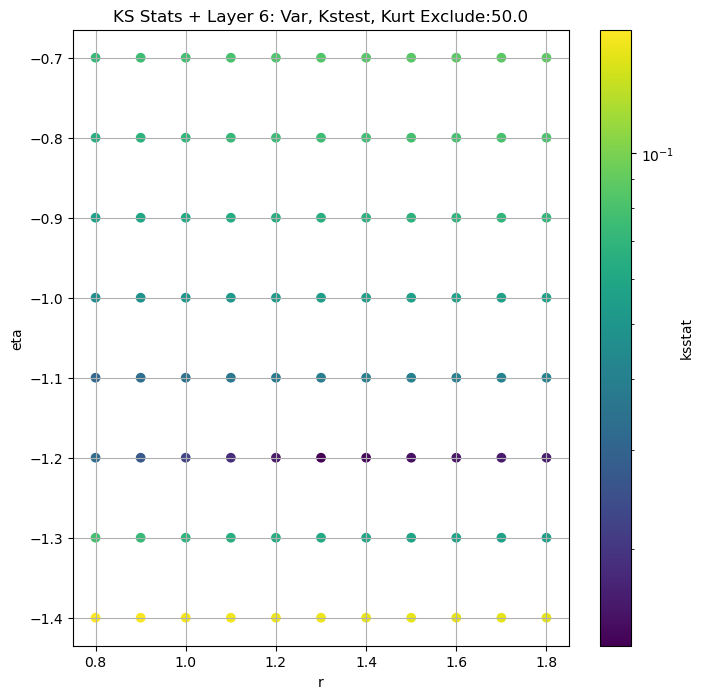

####
Layer  7


  0%|          | 0/7880 [00:00<?, ?it/s]

Finding Minimum after computing 7880 CDFs
7 0 0.013438255126623722 18.372583


  0%|          | 0/7880 [00:00<?, ?it/s]

Finding Minimum after computing 7880 CDFs
7 25 0.013225730678897096 17.207876


  0%|          | 0/7880 [00:00<?, ?it/s]

Finding Minimum after computing 7880 CDFs
7 50 0.013445836481514817 16.685886


  0%|          | 0/7880 [00:00<?, ?it/s]

Finding Minimum after computing 7880 CDFs
7 75 0.013459354557971426 16.273804
Number of samples: 100000, Without approximation : 17005000.0


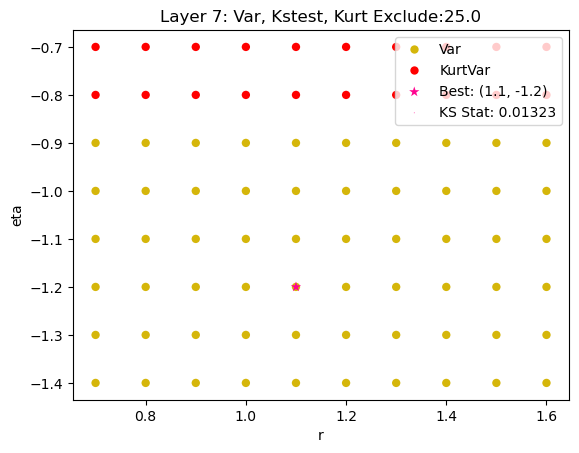

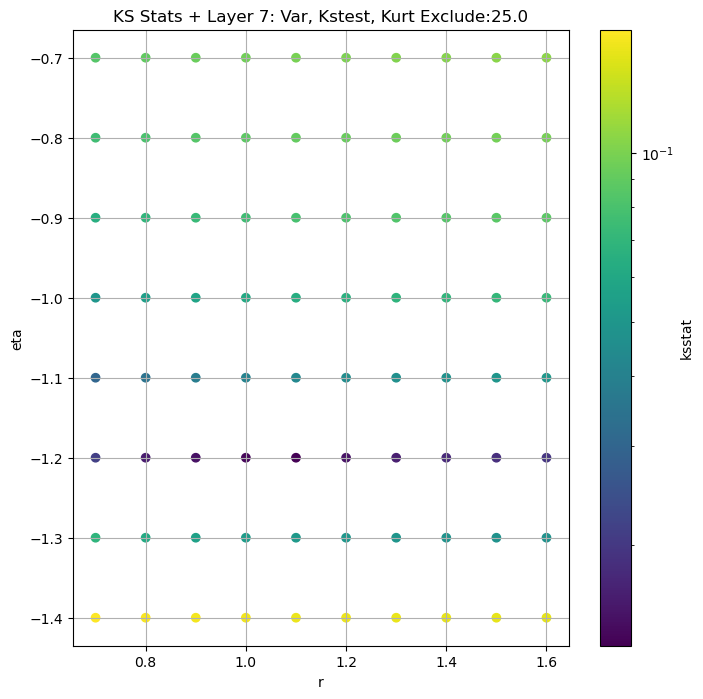

####
Layer  8


  0%|          | 0/7880 [00:00<?, ?it/s]

Finding Minimum after computing 7880 CDFs
8 0 0.010600791563670109 3.8336112


  0%|          | 0/7880 [00:00<?, ?it/s]

Finding Minimum after computing 7880 CDFs
8 25 0.012198572328465523 3.5047975


  0%|          | 0/7880 [00:00<?, ?it/s]

Finding Minimum after computing 7880 CDFs
8 50 0.013120423478632515 3.370999
Number of samples: 100000, Without approximation : 68020000.0


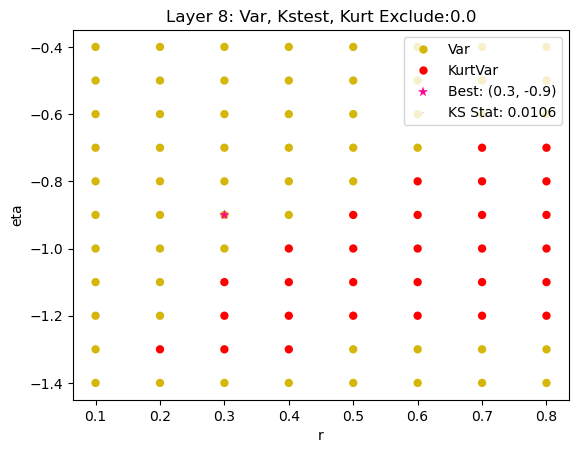

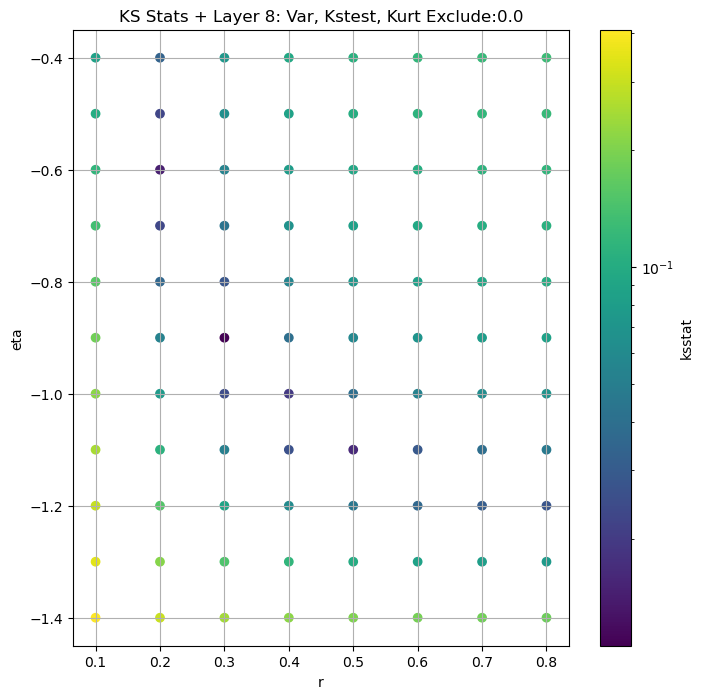

####
Layer  9


  0%|          | 0/7880 [00:00<?, ?it/s]

Finding Minimum after computing 7880 CDFs
9 0 0.008344877967048747 0.7227768


  0%|          | 0/7880 [00:00<?, ?it/s]

Finding Minimum after computing 7880 CDFs
9 25 0.0064508855175569035 0.62159365


  0%|          | 0/7880 [00:00<?, ?it/s]

Finding Minimum after computing 7880 CDFs
9 50 0.007402216596773981 0.59420246


  0%|          | 0/7880 [00:00<?, ?it/s]

Finding Minimum after computing 7880 CDFs
9 75 0.008255600215624909 0.57375175
Number of samples: 100000, Without approximation : 272080000.0


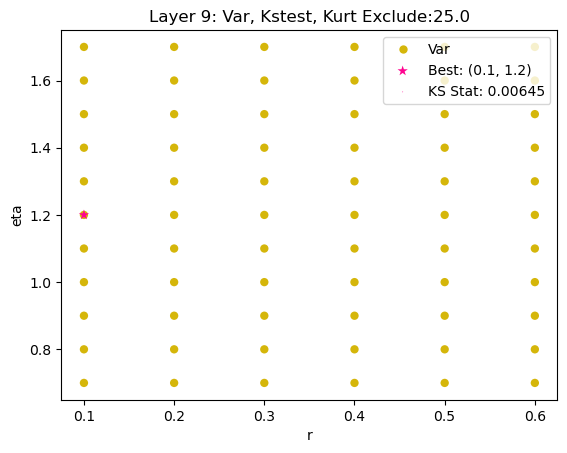

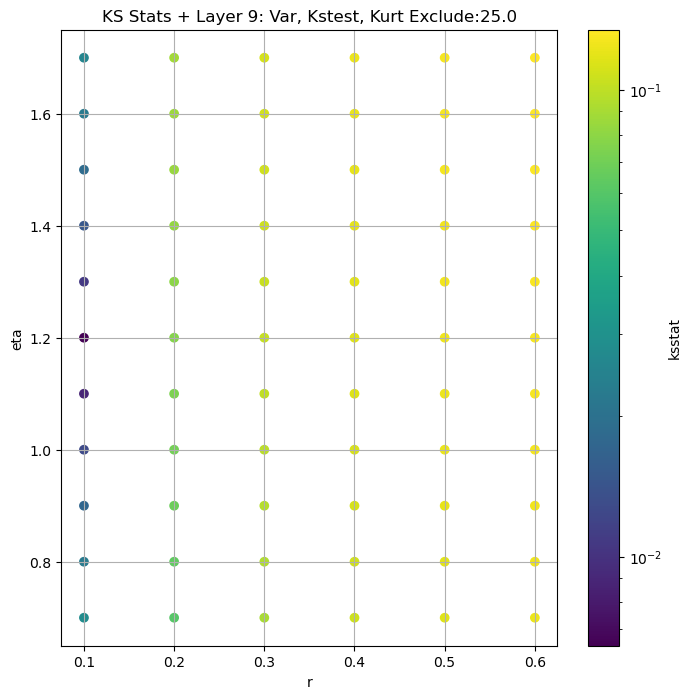

,obs_var,var_lower,var_upper,obs_kurt,kurt_lower,kurt_upper,total_samples,kstest_stat_initial,initial_r,initial_eta,initial_scale,initial_exclude_cutoff,best_augmented_var,kstest_stat_cutoff_0.05
layer,,,,,,,,,,,,,,
2,17099.951000,16011.873000,18266.027000,4.485870,2.916318,6.963518,27208.0,0.014667,2.4,-1.0,5.241135e+04,0.0,17099.951000,0.008227
3,4439.328600,4054.799300,4889.549300,11.246322,5.995842,23.188679,108832.0,0.131940,1.4,-1.2,1.810149e+04,0.0,4439.328600,0.004115
4,1375.095100,1259.372800,1507.274400,9.947575,6.166291,20.854307,333298.0,0.075010,1.4,-1.2,5.606989e+03,0.0,1375.095100,0.002352
5,383.261080,347.357240,432.744660,15.710056,6.790803,61.522090,1149538.0,0.039670,6.0,-1.3,2.458997e+03,0.0,383.261080,0.001267
6,87.512500,79.347590,97.938730,14.396328,7.234616,41.982544,4251250.0,0.013522,1.3,-1.2,3.193261e+02,50.0,80.927230,0.000659
7,18.372583,16.360443,21.660446,26.511518,9.414252,122.701400,17005000.0,0.013226,1.1,-1.2,6.164693e+01,25.0,17.207876,0.000329
8,3.833611,3.316390,4.837249,51.002052,13.016896,233.355440,68020000.0,0.010601,0.3,-0.9,9.553230e-02,0.0,3.833611,0.000165
9,0.722777,0.589432,1.182955,243.846040,15.030614,913.274840,272080000.0,0.006451,0.1,1.2,6.738922e-16,25.0,0.621594,0.000082


In [12]:
master_df_combo_path = Path(os.path.join(CWD, "CSVs", "master_df_combo.csv"))
rEtaKsstats_dict_path = Path(os.path.join(CWD, "cache", "rEtaKsstats_dict.pickle"))

rEtaKsstats_dict = dict()

if RERUN or not master_df_combo_path.exists():
    sorted_params = sorted(all_cdfs)
    ksstats_dict = dict()

    for i, group in enumerate(GROUPS): # TODO For quick testing purposes
        print(f"####\n{GROUP.capitalize()} ", group)
        sample = group_data_map[group]
        group_cdfs_df = all_cdfs_df.copy()
        master_df.loc[group, 'kstest_stat_initial'] = 1
        no_improvement_counter = 0

        for j in range(len(EXCLUDE_CUTOFFS)):

            exclude_cutoff = EXCLUDE_CUTOFFS[j]

            if no_improvement_counter > 1:
                break

            exclude_cutoff = int(exclude_cutoff)

            if exclude_cutoff == 0:
                augmented_var = np.var(group_data_map[group]) 
            else:
                augmented_var = np.var(group_data_map[group][exclude_cutoff:-exclude_cutoff])
                if augmented_var == np.var(group_data_map[group]):
                    continue 
                
            group_cdfs_df['scale'] = np.clip((augmented_var / group_cdfs_df['variance']), 0,  SCALE_CAP)
            ksstats, initial_param, min_stat = gridsearch(sample, all_cdfs, debug=True, scales=group_cdfs_df['scale'])
            augmented_var_df.loc[group, f"kstest_stat_{exclude_cutoff}"] = min_stat
            group_cdfs_df[f'ksstat_exclude_{exclude_cutoff}'] = ksstats
            
            print(group, exclude_cutoff, min_stat, augmented_var)
            
            if (min_stat < master_df.loc[group, 'kstest_stat_initial']) and not np.isclose(min_stat, master_df.loc[group, 'kstest_stat_initial'], 1e-6):
                inital_min_stat = min_stat
                inital_best_param = initial_param
                master_df.loc[group, 'kstest_stat_initial'] = min_stat
                initial_scale = group_cdfs_df.loc[(group_cdfs_df["r"] ==  initial_param[0]) & (group_cdfs_df["eta"] ==  initial_param[1])]["scale"].iloc[0]
                master_df.loc[group, 'initial_r'], master_df.loc[group, 'initial_eta'] = initial_param
                master_df.loc[group, 'initial_scale'] = initial_scale
                master_df.loc[group, 'initial_exclude_cutoff'] = exclude_cutoff
                master_df.loc[group, 'best_augmented_var'] = augmented_var
            else:
                no_improvement_counter += 1
        
        ksstats = group_cdfs_df[f"ksstat_exclude_{int(master_df.loc[group, 'initial_exclude_cutoff'])}"]
            
        print(f"Number of samples: {sample.size}, Without approximation : {master_df.loc[group, 'total_samples']}")
        
        cutoff = stats.kstwo(n=master_df.loc[group, 'total_samples']).isf(0.05)
        master_df.loc[group, 'kstest_stat_cutoff_0.05'] = cutoff

        best_scales = np.clip((master_df.loc[group, 'best_augmented_var'] / group_cdfs_df['variance']), 0,  SCALE_CAP)

        group_cdfs_df['variance'] = group_cdfs_df['variance'] * best_scales
        group_cdfs_df['kurtosis'] = group_cdfs_df['kurtosis'] * best_scales

        group_cdfs_df = add_tests_to_df(cdfs_df = group_cdfs_df, group = group, var_kurt_df = master_df, ksstats = ksstats).sort_values(['r', 'eta'])

        group_dict = {'r' : group_cdfs_df['r'], 'eta' : group_cdfs_df['eta']}
        group_dict.update({f'ksstat_exclude_{exclude_cutoff}' : group_cdfs_df[f'ksstat_exclude_{exclude_cutoff}'] for exclude_cutoff in EXCLUDE_CUTOFFS[:j]})
        rEtaKsstats_dict[group] = group_dict

        cols = ['pass_var', 'pass_kstest', 'pass_kurt']

        fig = combo_test_plot(group_cdfs_df, cols, 
                            plot_name=f"{GROUP.capitalize()} {group}: {', '.join([col[5:].capitalize() for col in cols])} Exclude:{master_df.loc[group, 'initial_exclude_cutoff']}", 
                            target_var = None,
                            best_param = inital_best_param,
                            best_ksstat=inital_min_stat
                            )
        
        fig.figure.savefig(os.path.join(CWD, "plots", f"full_grid_search_combo_plot_layer{group}.jpg"), bbox_inches = 'tight', dpi=100)

        # Optional: 
        # Create plots of bootstrapped variance and kurtosis for varying confidence intervals
        # fig_var = create_ci_scatter_plot(group_cdfs_df, var_values_dict, metric='variance', group=group)
        # fig_kurt = create_ci_scatter_plot(group_cdfs_df, kurt_values_dict, metric='kurtosis', group=group)

        # fig_var.savefig(os.path.join(CWD, "plots", f"ci_scatter_variance_{GROUP}_{group}_bootstrap{n_bootstrap}.jpg"), bbox_inches='tight')
        # plt.close(fig_var)
        # fig_kurt.savefig(os.path.join(CWD, "plots", f"ci_scatter_variance_{GROUP}_{group}_bootstrap{n_bootstrap}.jpg"), bbox_inches='tight')
        # plt.close(fig_kurt)

    master_df.to_csv(master_df_combo_path)
    pd.to_pickle(rEtaKsstats_dict, rEtaKsstats_dict_path)
    augmented_var_df.to_csv(augmented_var_df_path)

augmented_var_df = pd.read_csv(augmented_var_df_path, index_col=GROUP)
master_df = pd.read_csv(master_df_combo_path, index_col=GROUP)
rEtaKsstats_dict = pd.read_pickle(rEtaKsstats_dict_path)
master_df

In [13]:
augmented_var_df

,obs_var,var_exclude_0,var_exclude_25,var_exclude_50,var_exclude_75,var_exclude_100,var_exclude_150,var_exclude_200,var_exclude_250,var_exclude_300,var_exclude_350,var_exclude_500,kstest_stat_0,kstest_stat_25,kstest_stat_50,kstest_stat_75
layer,,,,,,,,,,,,,,,,
2,17099.951000,17099.951000,16030.946000,15466.998000,15026.830000,14642.879000,13979.686000,13403.717000,12901.043000,12449.383000,12033.921000,10956.670000,0.014667,0.014747,0.014783,NaN
3,4439.328600,4439.328600,4233.756000,4140.746000,4064.417200,4000.475800,3890.007300,3793.830600,3707.581000,3629.487000,3558.295000,3370.039000,0.131940,0.131940,0.131940,NaN
4,1375.095100,1375.095100,1318.398700,1287.501700,1263.283000,1242.287000,1206.405600,1175.987800,1149.096100,1124.818500,1102.432600,1043.945800,0.075010,0.075010,0.075010,NaN
5,383.261080,383.261080,363.919500,354.908400,347.653170,341.437070,331.056000,322.332820,314.621980,307.621460,301.190980,284.354600,0.039670,0.039670,0.039670,NaN
6,87.512500,87.512500,83.097840,80.927230,79.221344,77.756240,75.284225,73.199030,71.365100,69.713620,68.203450,64.275720,0.013915,0.013956,0.013522,0.013895
7,18.372583,18.372583,17.207876,16.685886,16.273804,15.923417,15.334048,14.839373,14.406991,14.019738,13.667419,12.761007,0.013438,0.013226,0.013446,0.013459
8,3.833611,3.833611,3.504798,3.370999,3.267645,3.181046,3.037758,2.919637,2.817884,2.727952,2.647056,2.442562,0.010601,0.012199,0.013120,NaN
9,0.722777,0.722777,0.621594,0.594202,0.573752,0.556946,0.529689,0.507625,0.488885,0.472483,0.457841,0.421251,0.008345,0.006451,0.007402,0.008256


In [14]:
master_df['kstest_stat_best'] = master_df['kstest_stat_initial']
master_df[f'best_r'] = master_df['initial_r']
master_df[f'best_eta'] = master_df['initial_eta']
master_df[f'best_scale'] = master_df['initial_scale']
master_df[f'best_exclude_cutoff'] = master_df['initial_exclude_cutoff']

In [15]:
master_df_optimized_path = Path(os.path.join(CWD, "CSVs", 'master_df_optimized.csv'))

NUM_ITERS = dict(zip(GROUPS, [1]*len(GROUPS))) # By default, does one iteration per group
NUM_SAMPLES_OPTIMIZE = 2000
EXCLUDE_CUTOFFS_OPTIMIZE = np.arange(-50, 51, 10)

if RERUN or not master_df_optimized_path.exists():

    if SKIP_OPTIMIZE_STEP:

        master_df['kstest_stat_best'] = master_df['kstest_stat_initial']
        master_df[f'best_r'] = master_df['initial_r']
        master_df[f'best_eta'] = master_df['initial_eta']
        master_df[f'best_scale'] = master_df['initial_scale']
        master_df[f'best_exclude_cutoff'] = master_df['initial_exclude_cutoff']

    else:
        for group in GROUPS: # TODO For quick testing purposes
            print(f"{GROUP.capitalize()} {group}")
            master_df.loc[group, 'kstest_stat_best'] = master_df.loc[group, 'kstest_stat_initial']
            master_df.loc[group, 'best_r'] = master_df.loc[group, 'initial_r']
            master_df.loc[group, 'best_eta'] = master_df.loc[group, 'initial_eta']
            master_df.loc[group, 'best_scale'] = master_df.loc[group, 'initial_scale']

            sample = group_data_map[group]
            initial_r, initial_eta = master_df.loc[group, 'initial_r'], master_df.loc[group, f'initial_eta']
            r_granularity = 1
            eta_granularity = 1
            for i in range(0, -5, -1):
                if tuple([round_to_sigfigs(initial_r + 10.**i, 8), round_to_sigfigs(initial_eta, 1)]) in all_cdfs:
                    r_granularity = 10.**i
                if tuple([round_to_sigfigs(initial_r, 1), round_to_sigfigs(initial_eta + 10.**i, 8)]) in all_cdfs:
                    eta_granularity = 10.**i
                    
            for d in range(1, NUM_ITERS[group] + 1):
                if d == 1:
                    initial_r, initial_eta = master_df.loc[group, 'initial_r'], master_df.loc[group, f'initial_eta']
                else:
                    initial_r, initial_eta = master_df.loc[group, f'iter{d - 1}_r'], master_df.loc[group, f'iter{d - 1}_eta']

                r_granularity = r_granularity * 10.0**(-d+1) 
                eta_granularity = eta_granularity * 10.0**(-d+1) 

                r_range = [round_to_sigfigs(x) for x in np.arange(initial_r - r_granularity, initial_r + r_granularity, r_granularity/10)]
                eta_range = [round_to_sigfigs(x) for x in np.arange(initial_eta - eta_granularity, initial_eta + eta_granularity, eta_granularity/10)]
                simple_add_cdfs(r_range, eta_range, dir = os.path.join(CWD, "groupCDFs"), folder_name=f'{GROUP}{group}', n_samples = NUM_SAMPLES_OPTIMIZE, debug=False, tail_bound=1e-5)
                group_cdfs = combine_pickles(os.path.join(CWD, "groupCDFs", f'{GROUP}{group}'))
                group_cdfs_df = create_kurt_var_ksstat_df(group_cdfs)

                for adjust_exclude_cutoff in EXCLUDE_CUTOFFS_OPTIMIZE: # -50, -25, 0, 25, 50
                    exclude_cutoff = int(max(0, adjust_exclude_cutoff + master_df.loc[group, 'initial_exclude_cutoff']))
                    
                    if exclude_cutoff == 0:
                        augmented_var = np.var(group_data_map[group])
                    else:
                        augmented_var = np.var(group_data_map[group][exclude_cutoff:-exclude_cutoff])                       

                    group_cdfs_df['scale'] = np.clip((augmented_var / group_cdfs_df['variance']), 0,  SCALE_CAP)
                    ksstats, initial_param, min_stat = gridsearch(sample, group_cdfs, debug=True, scales=group_cdfs_df['scale'])
                    
                    cutoff_label = generate_cutoff_label(adjust_exclude_cutoff)

                    augmented_var_df.loc[group, f"kstest_stat_{cutoff_label}"] = min_stat
                    group_cdfs_df[f'ksstat_exclude_{cutoff_label}'] = ksstats
                    
                    print(group, adjust_exclude_cutoff, exclude_cutoff, min_stat, augmented_var, cutoff_label)
                    best_adjust = 0

                    if min_stat < master_df.loc[group, 'kstest_stat_best']:

                        inital_min_stat = min_stat
                        inital_best_param = initial_param
                        master_df.loc[group, 'kstest_stat_best'] = min_stat
                        initial_scale = group_cdfs_df.loc[(group_cdfs_df["r"] ==  initial_param[0]) & (group_cdfs_df["eta"] ==  initial_param[1])]["scale"].iloc[0]
                        master_df.loc[group, 'best_r'], master_df.loc[group, 'best_eta'] = initial_param
                        master_df.loc[group, 'best_scale'] = initial_scale
                        master_df.loc[group, 'best_exclude_cutoff'] = exclude_cutoff
                        master_df.loc[group, 'best_augmented_var'] = augmented_var
                        augmented_var_df.loc[group, 'best_augmented_var'] = augmented_var
                        best_adjust = adjust_exclude_cutoff

                cutoff_label = generate_cutoff_label(best_adjust)
                ksstats = group_cdfs_df[f"ksstat_exclude_{best_adjust}"]
                
                print(f"Number of samples: {sample.size}, Without approximation : {master_df.loc[group, 'total_samples']}")
                
                cutoff = stats.kstwo(n=master_df.loc[group, 'total_samples']).isf(0.05)
                master_df.loc[group, 'kstest_stat_cutoff_0.05'] = cutoff

                best_scales = np.clip((master_df.loc[group, 'best_augmented_var'] / group_cdfs_df['variance']), 0,  SCALE_CAP)

                group_cdfs_df['variance'] = group_cdfs_df['variance'] * best_scales
                group_cdfs_df['kurtosis'] = group_cdfs_df['kurtosis'] * best_scales

                group_cdfs_df = add_tests_to_df(cdfs_df = group_cdfs_df, group = group, var_kurt_df = master_df, ksstats = ksstats).sort_values(['r', 'eta'])

                group_dict = rEtaKsstats_dict[group]
                group_dict.update({'r_optimize' : group_cdfs_df['r'], 'eta_optimize' : group_cdfs_df['eta'], f'ksstat_exclude_{cutoff_label}' : ksstats})
                rEtaKsstats_dict[group] = group_dict

                print(f"Iter {d} {GROUP} {group} best parameters: {master_df.loc[group, 'best_r'], master_df.loc[group, 'best_eta'], master_df.loc[group, 'best_scale'], master_df.loc[group, 'best_exclude_cutoff'], master_df.loc[group, f'kstest_stat_best']}")

            filtered_df = group_cdfs_df[(group_cdfs_df['r'] > master_df.loc[group, 'initial_r'] - r_granularity) & 
                            (group_cdfs_df['r'] < master_df.loc[group, 'initial_r'] + r_granularity) &
                            (group_cdfs_df['eta'] > master_df.loc[group, 'initial_eta'] - eta_granularity) &
                            (group_cdfs_df['eta'] < master_df.loc[group, 'initial_eta'] + eta_granularity)]
            
            cols = ['pass_var', 'pass_kstest', 'pass_kurt']
            fig = combo_test_plot(filtered_df, cols, 
                                plot_name=f"{GROUP.capitalize()} {group} zoomed in: {', '.join([col[5:].capitalize() for col in cols])}  Exclude:{master_df.loc[group, 'best_exclude_cutoff']}",
                                best_param=(master_df.loc[group, 'best_r'], master_df.loc[group, f'best_eta']),
                                best_ksstat=master_df.loc[group, 'kstest_stat_best'])
            fig.figure.savefig(os.path.join(CWD, "plots", f"optimized_full_grid_search_combo_plot_layer{group}.jpg"), bbox_inches = 'tight', dpi=100)
            
    master_df['n_pval_0.05'] = master_df.apply(lambda row : find_n_fixed_pval_stat(row.loc['kstest_stat_best'], row.loc['total_samples']), axis = 1)    
    master_df[['total_samples', 'initial_r', 'initial_eta', 'kstest_stat_initial', 'initial_exclude_cutoff', 'best_r', 'best_eta', 'best_scale', 'kstest_stat_best', 'best_exclude_cutoff', 'n_pval_0.05']].to_csv(os.path.join(CWD, "CSVs", 'optimized_params.csv'))
    master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df_optimized.csv'))
    augmented_var_df.to_csv(augmented_var_df_path)

master_df = pd.read_csv(master_df_optimized_path, index_col = GROUP)
augmented_var_df = pd.read_csv(augmented_var_df_path, index_col = GROUP)
master_df

,obs_var,var_lower,var_upper,obs_kurt,kurt_lower,kurt_upper,total_samples,kstest_stat_initial,initial_r,initial_eta,initial_scale,initial_exclude_cutoff,best_augmented_var,kstest_stat_cutoff_0.05,kstest_stat_best,best_r,best_eta,best_scale,best_exclude_cutoff,n_pval_0.05
layer,,,,,,,,,,,,,,,,,,,,
2,17099.951000,16011.873000,18266.027000,4.485870,2.916318,6.963518,27208.0,0.014667,2.4,-1.0,5.241135e+04,0.0,17099.951000,0.008227,0.014667,2.4,-1.0,5.241135e+04,0.0,8607
3,4439.328600,4054.799300,4889.549300,11.246322,5.995842,23.188679,108832.0,0.131940,1.4,-1.2,1.810149e+04,0.0,4439.328600,0.004115,0.131940,1.4,-1.2,1.810149e+04,0.0,106
4,1375.095100,1259.372800,1507.274400,9.947575,6.166291,20.854307,333298.0,0.075010,1.4,-1.2,5.606989e+03,0.0,1375.095100,0.002352,0.075010,1.4,-1.2,5.606989e+03,0.0,325
5,383.261080,347.357240,432.744660,15.710056,6.790803,61.522090,1149538.0,0.039670,6.0,-1.3,2.458997e+03,0.0,383.261080,0.001267,0.039670,6.0,-1.3,2.458997e+03,0.0,1122
6,87.512500,79.347590,97.938730,14.396328,7.234616,41.982544,4251250.0,0.013522,1.3,-1.2,3.193261e+02,50.0,80.927230,0.000659,0.013522,1.3,-1.2,3.193261e+02,50.0,10507
7,18.372583,16.360443,21.660446,26.511518,9.414252,122.701400,17005000.0,0.013226,1.1,-1.2,6.164693e+01,25.0,17.207876,0.000329,0.013226,1.1,-1.2,6.164693e+01,25.0,10507
8,3.833611,3.316390,4.837249,51.002052,13.016896,233.355440,68020000.0,0.010601,0.3,-0.9,9.553230e-02,0.0,3.833611,0.000165,0.010601,0.3,-0.9,9.553230e-02,0.0,16606
9,0.722777,0.589432,1.182955,243.846040,15.030614,913.274840,272080000.0,0.006451,0.1,1.2,6.738922e-16,25.0,0.621594,0.000082,0.006451,0.1,1.2,6.738922e-16,25.0,44883


## Comparing Empirical and Computed CDF/PDF

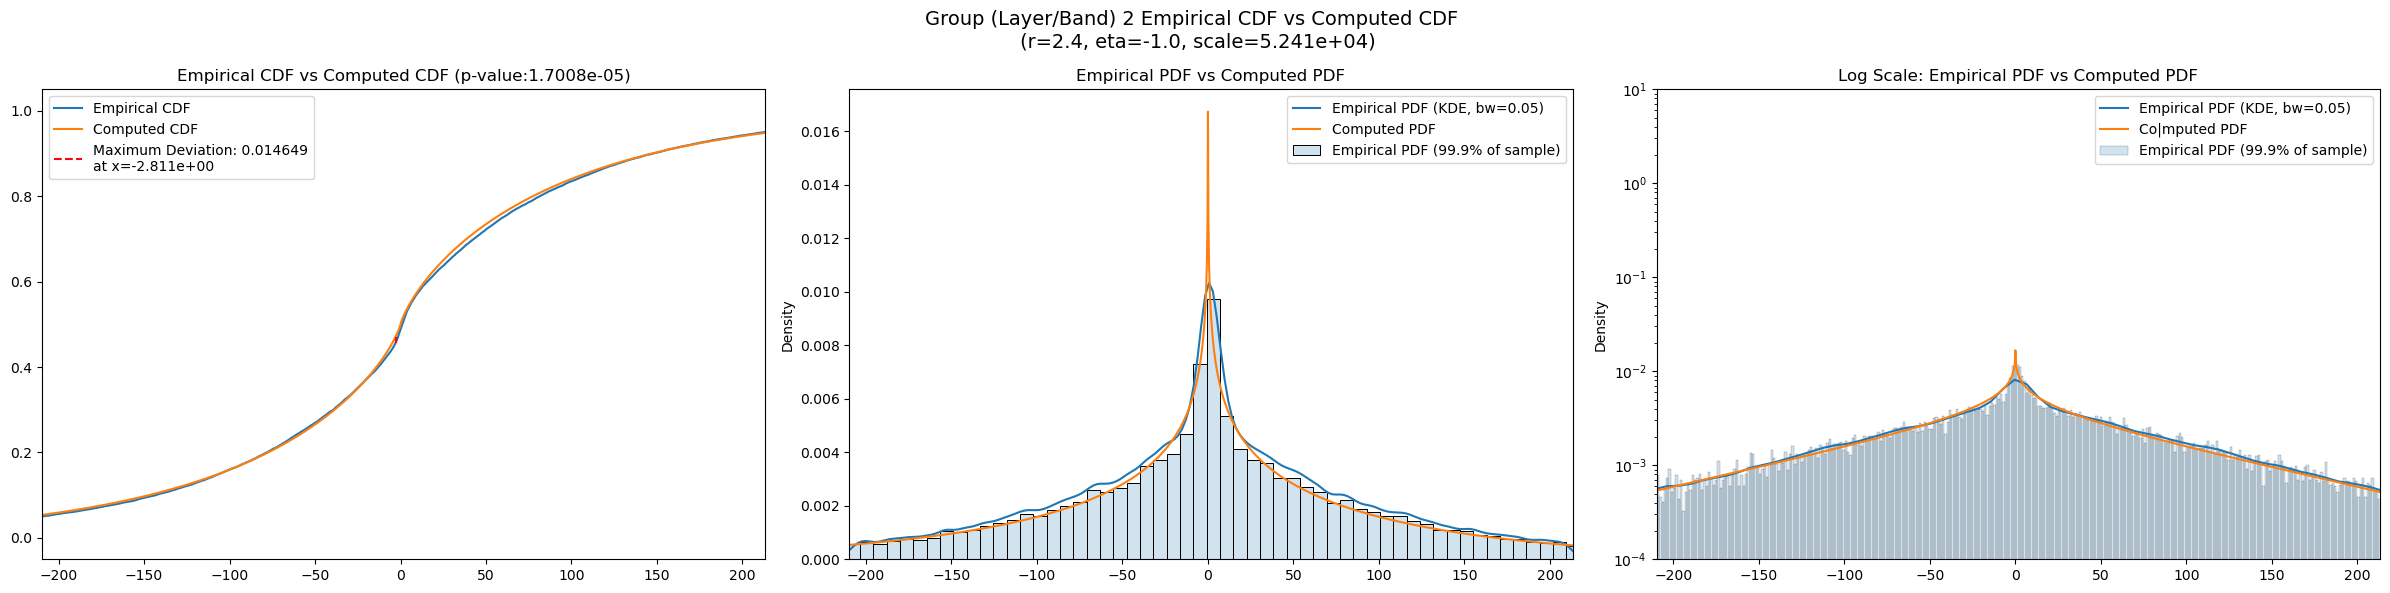

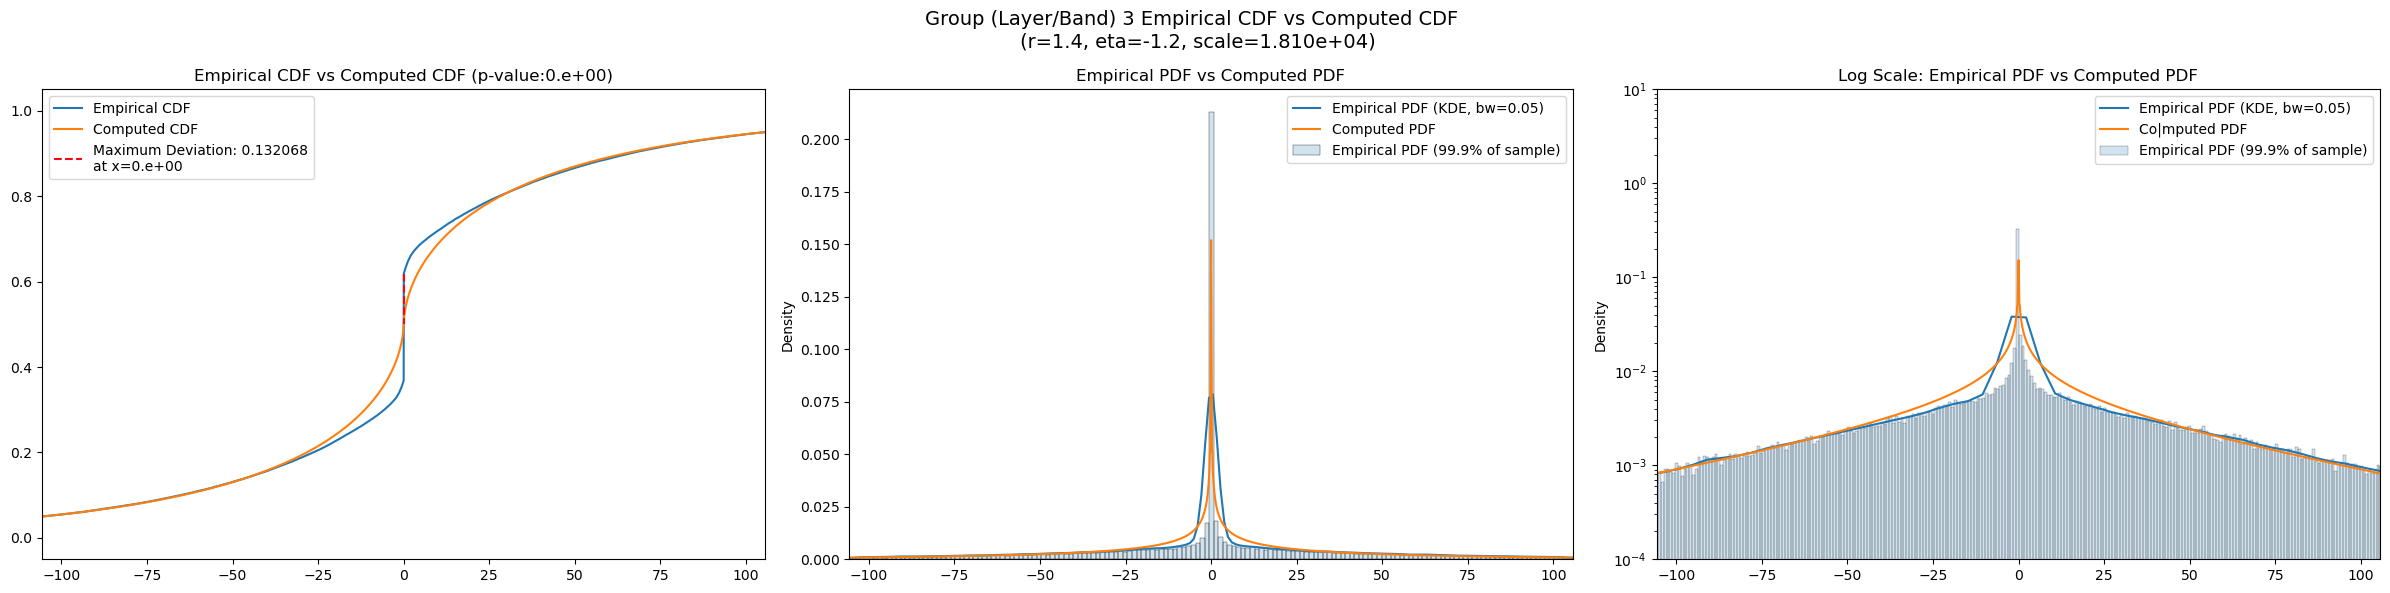

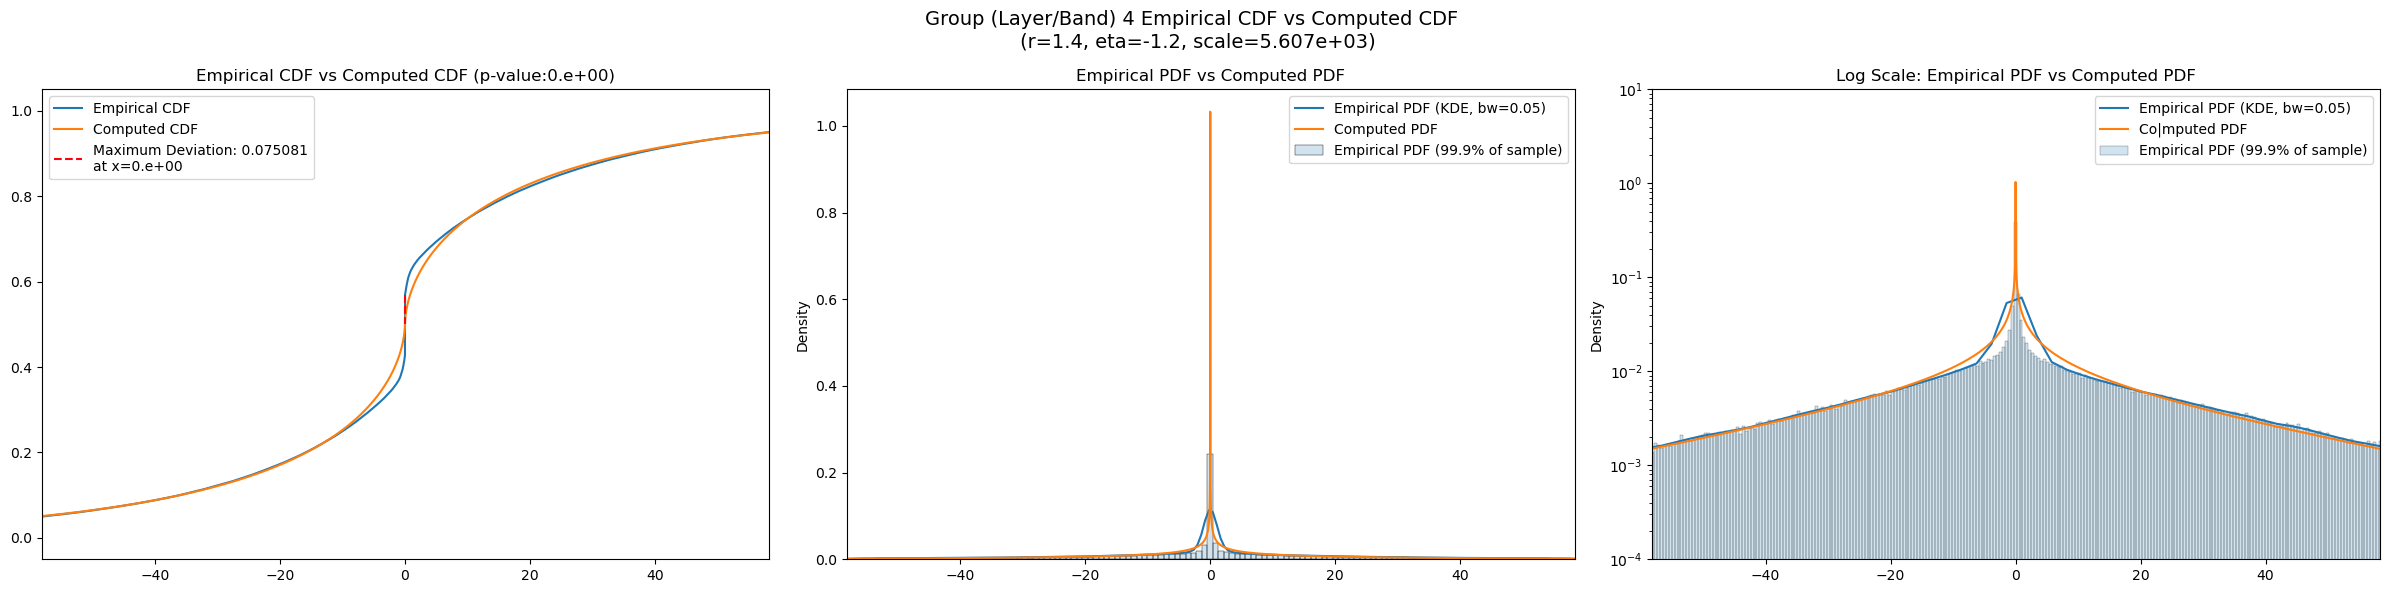

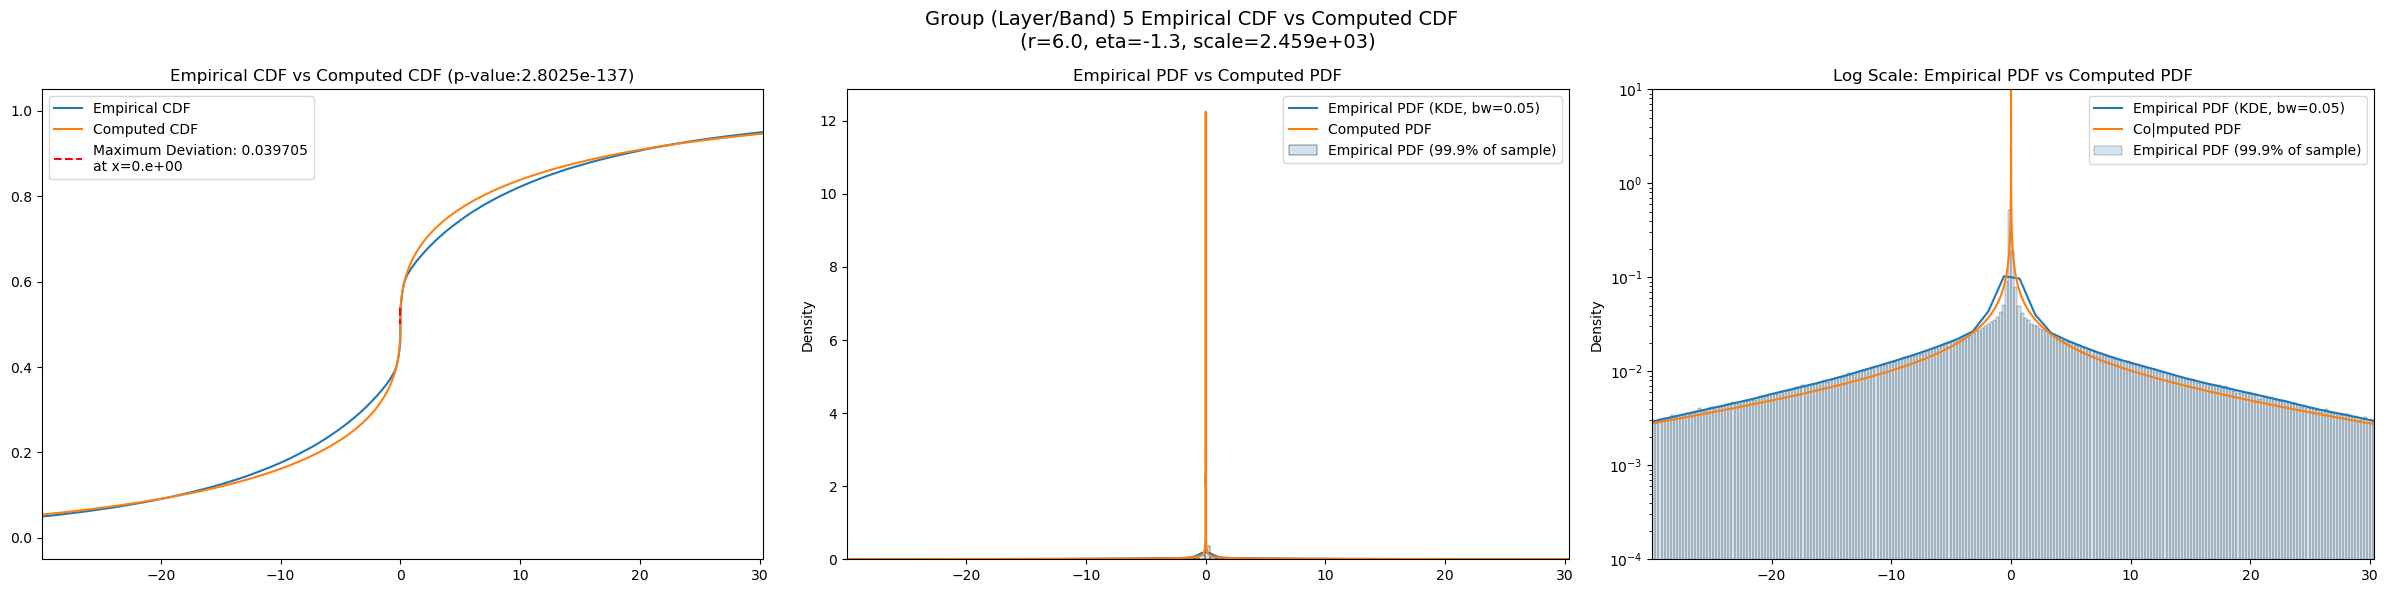

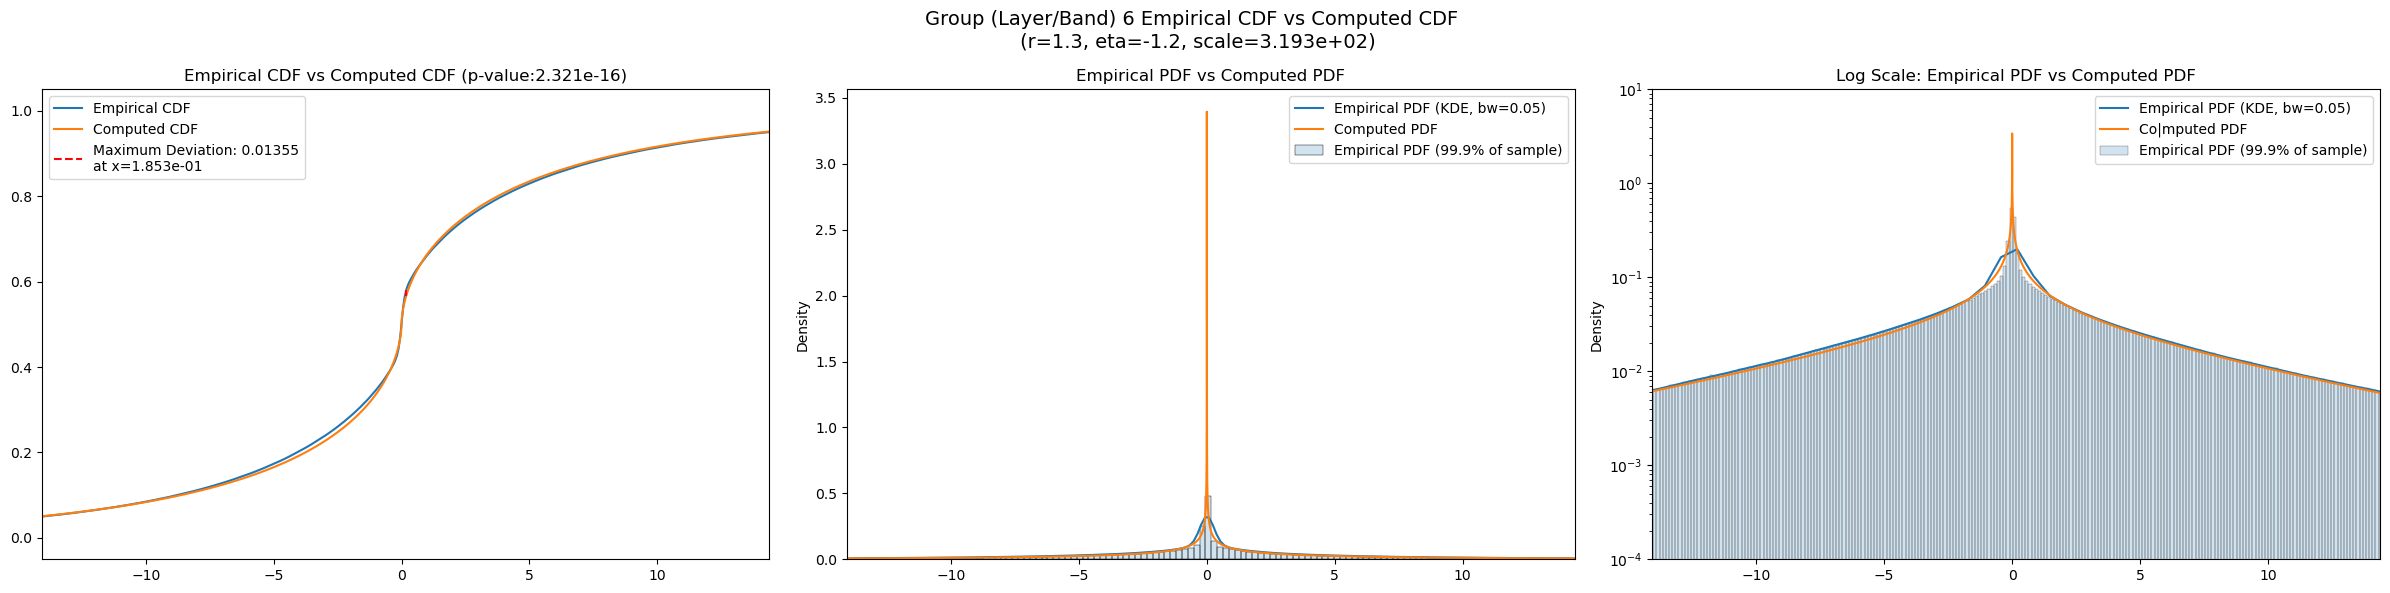

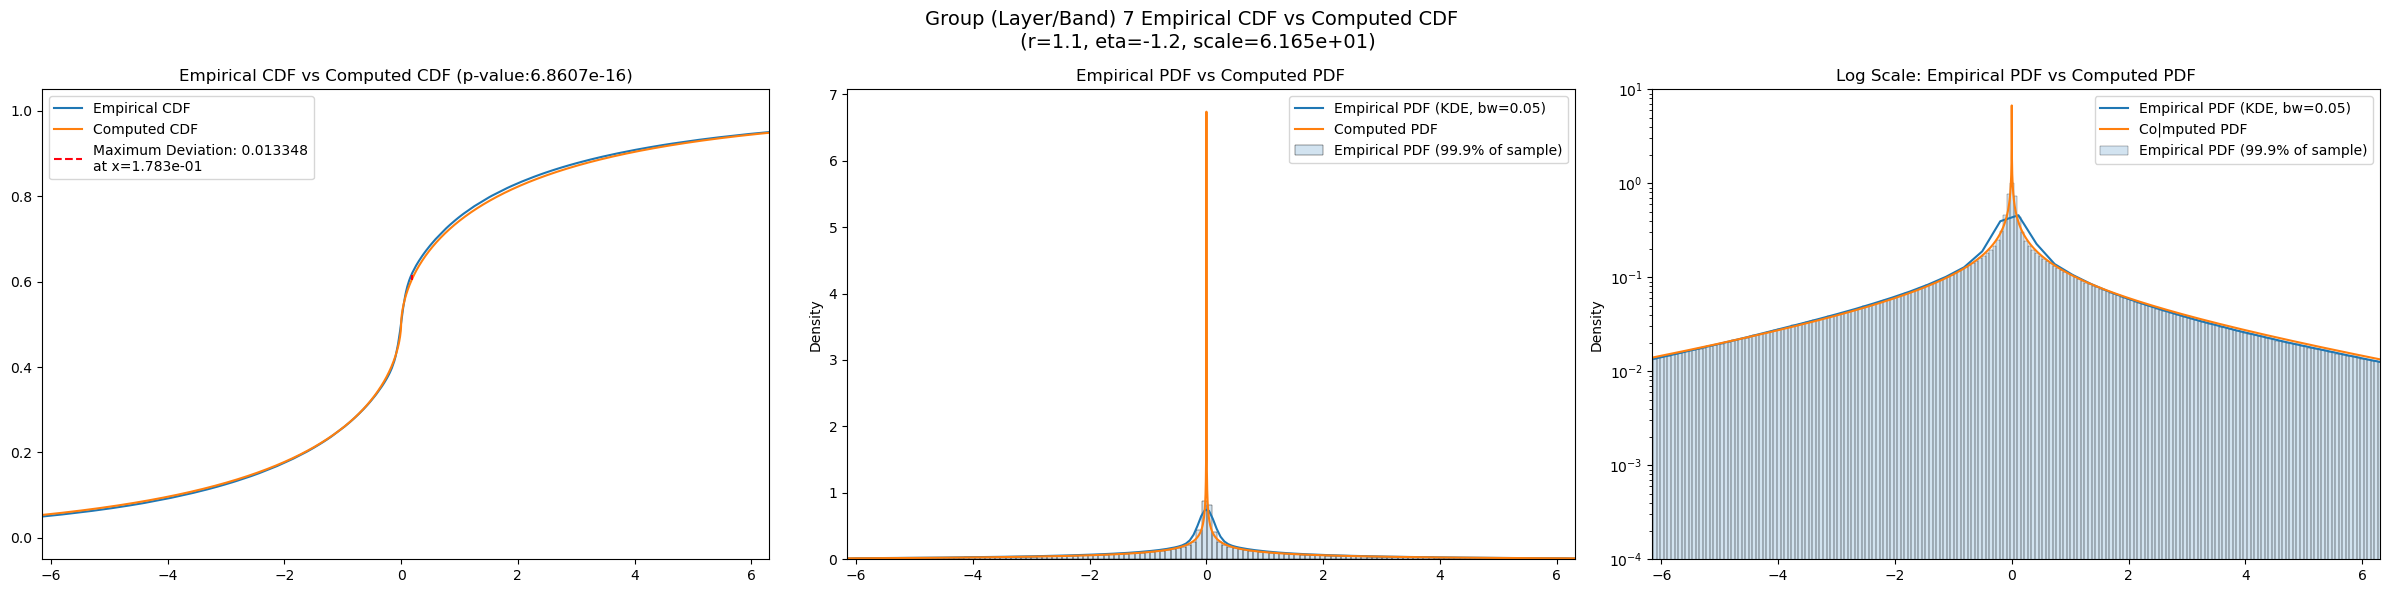

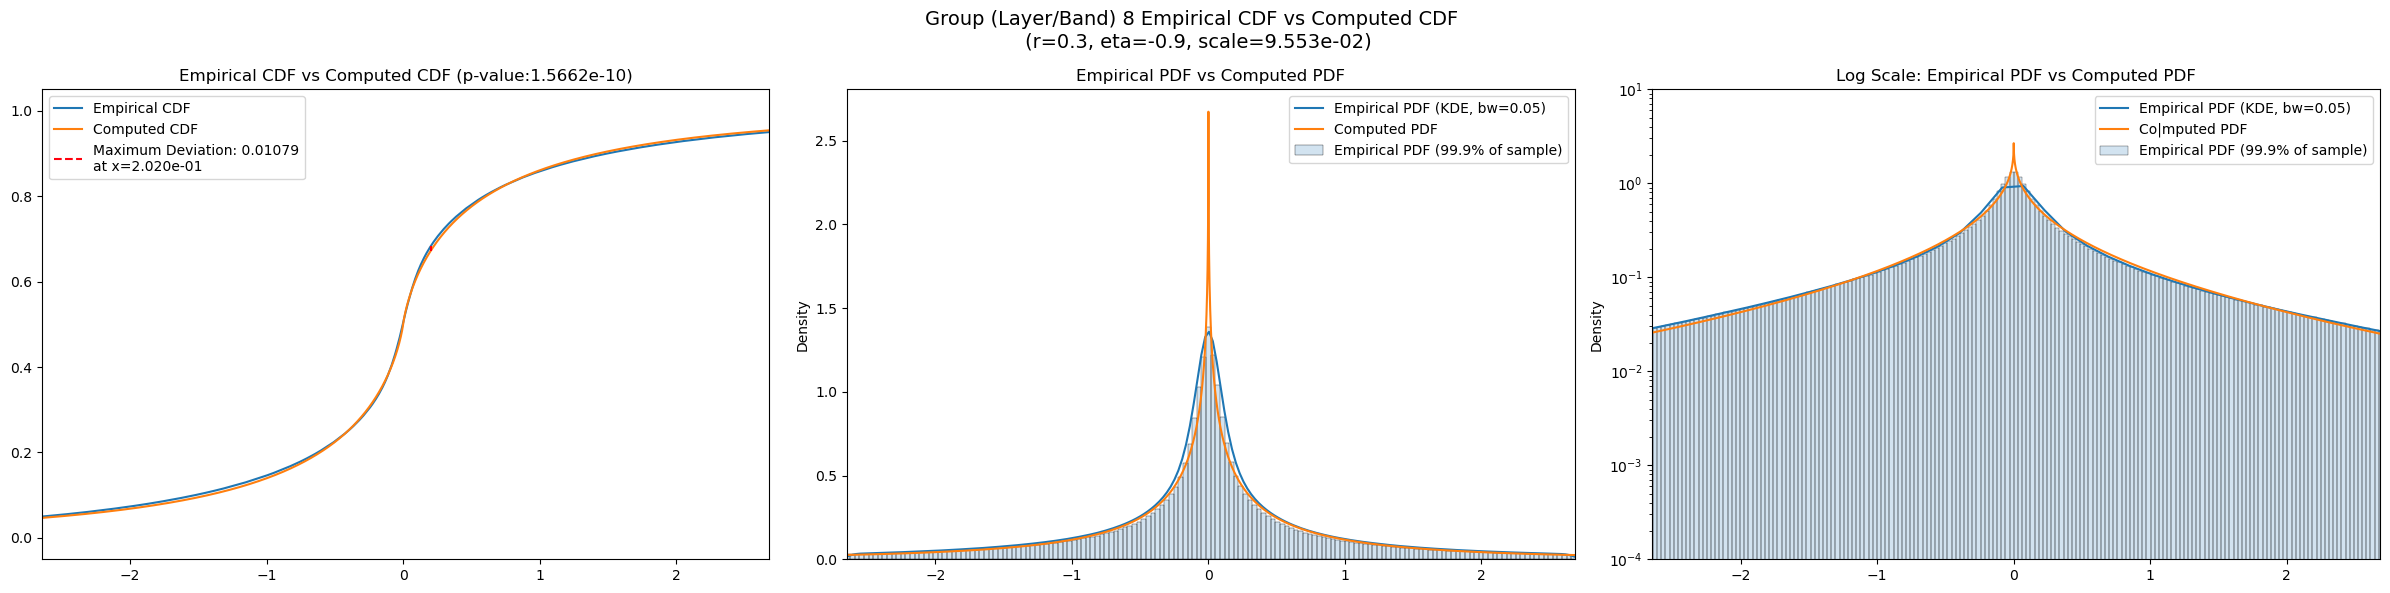

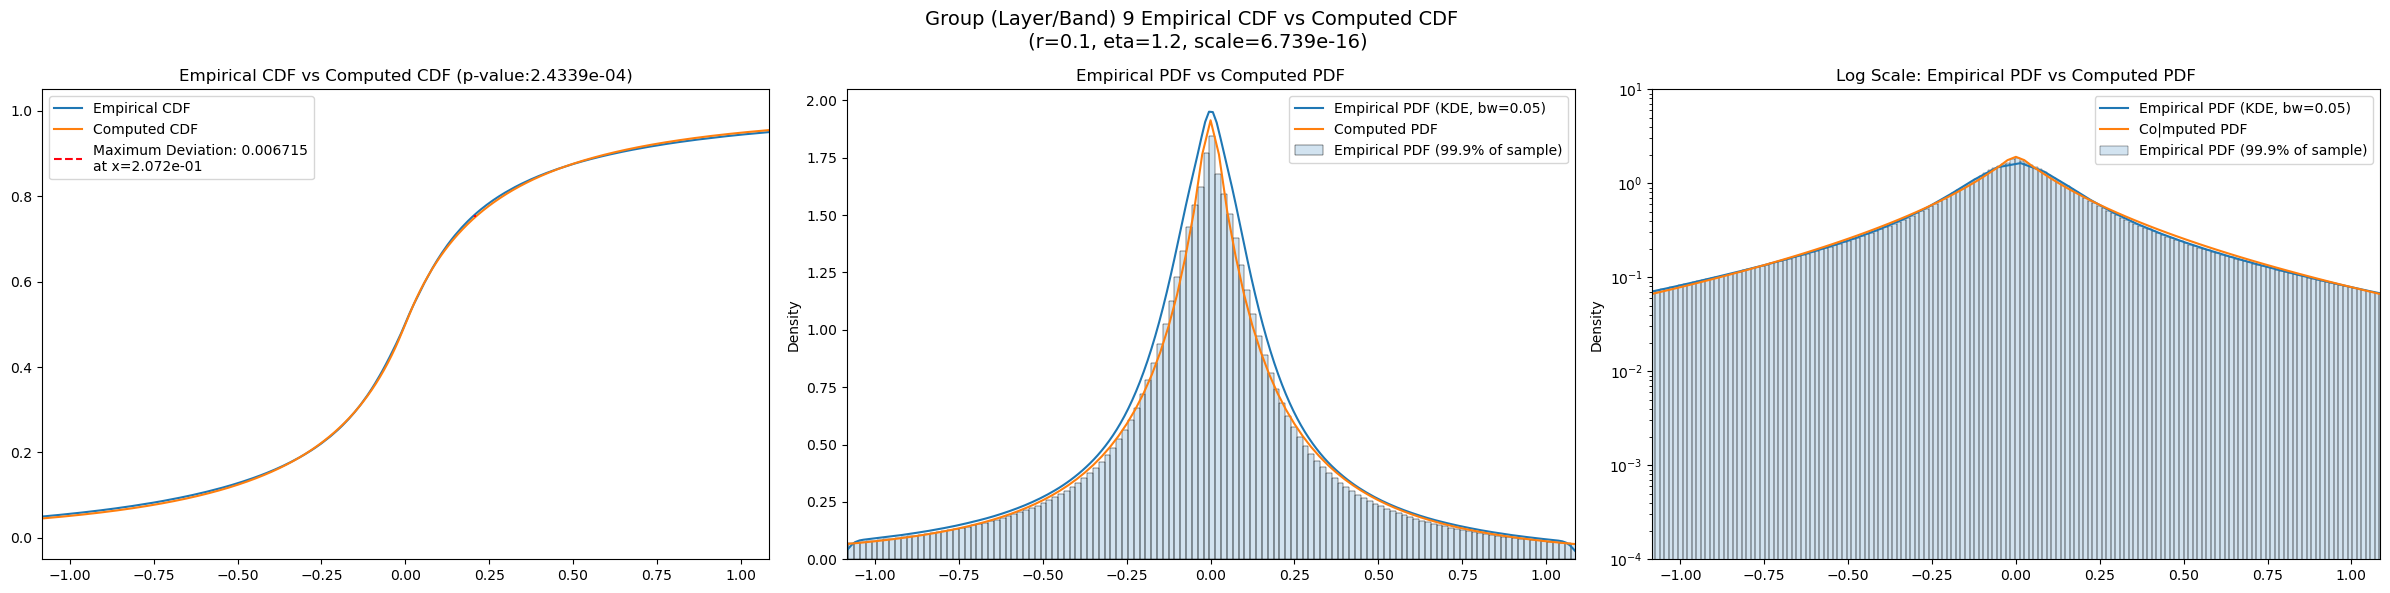

In [16]:
for group in GROUPS:
    group_info = master_df.loc[group]
    best_r = group_info['best_r']
    best_eta = group_info['best_eta']
    best_scale = group_info['best_scale']
    fig = visualize_cdf_pdf(sample = group_data_map[group], 
                    params = (best_r, best_eta, best_scale), 
                    log_scale = True,
                    group = group)
    fig.savefig(os.path.join(CWD, "plots", f'compare_cdf_pdf_layer_{group}.jpg'), bbox_inches = 'tight', dpi = 100)

## Comparing with Gaussian and Laplace Priors

In [17]:
def generate_func(sample, distro, *args, n_samples=200):
    if distro == 'gaussian' or distro == 'normal':
        def var_func(var):
            cdf = scipy.stats.norm(scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'laplace':
        def var_func(var):
            cdf = scipy.stats.laplace(scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 't':
        def var_func(var):
            cdf = scipy.stats.t(df=2, scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'prior_r':
        eta = args[0]
        def r_func(r):
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples)
            return compute_ksstat(sample, cdf)
        return r_func
    elif distro == 'prior_eta':
        r = args[0]
        def eta_func(eta):
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples)
            return compute_ksstat(sample, cdf)
        return eta_func
    elif distro == 'prior':
        def r_eta_func(params):
            r = params[0]
            eta = params[1]
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples, debug=False)
            return compute_ksstat(sample, cdf)
        return r_eta_func
    elif distro == 'prior_with_scale':
        def r_eta_scale_func(params):
            r = params[0]
            eta = params[1]
            scale = params[2]
            print(r, eta, scale)
            cdf = compute_prior_cdf(r = r, eta = eta, n_samples=n_samples, debug=False)
            return compute_ksstat(sample/ np.sqrt(scale), cdf)
        return r_eta_scale_func

    print("Please enter a valid argument for `distro`: 'gaussian', 'laplace', 'prior_r', 'prior_eta', 'prior','prior_with_scale', 't'")

In [18]:
master_df_path = Path(os.path.join(CWD, "CSVs", 'master_df.csv'))

if RERUN or not master_df_path.exists():
    upper_bound = int(1e6)
    for group in GROUPS:
        norm_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'gaussian'), method = 'bounded', bounds = (0, upper_bound))
        laplace_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'laplace'), method = 'bounded', bounds = (0, upper_bound))
        t_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 't'), method = 'bounded', bounds = (0, upper_bound))
        
        master_df.loc[group, 'param_gaussian'] = round_to_sigfigs(norm_result['x'], 6)
        master_df.loc[group, 'kstest_stat_gaussian'] = round_to_sigfigs(norm_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_gaussian'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_gaussian']), 6)

        master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
        master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6)

        master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
        master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6) 

        master_df.loc[group, 'param_t'] = round_to_sigfigs(t_result['x'], 6)
        master_df.loc[group, 'kstest_stat_t'] = round_to_sigfigs(t_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_t'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_t']), 6) 

        master_df.loc[group, 'kstest_pval_gengamma'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_best']))

    master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df.csv'))
    
master_df = pd.read_csv(os.path.join(CWD, "CSVs", 'master_df.csv'), index_col = GROUP)
master_df

,obs_var,var_lower,var_upper,obs_kurt,kurt_lower,kurt_upper,total_samples,kstest_stat_initial,initial_r,initial_eta,...,param_gaussian,kstest_stat_gaussian,kstest_pval_gaussian,param_laplace,kstest_stat_laplace,kstest_pval_laplace,param_t,kstest_stat_t,kstest_pval_t,kstest_pval_gengamma
layer,,,,,,,,,,,,,,,,,,,,,
2,17099.951000,16011.873000,18266.027000,4.485870,2.916318,6.963518,27208.0,0.014667,2.4,-1.0,...,93.496000,0.045673,9.282710e-50,77.895200,0.028189,3.239890e-19,65.682200,0.032581,1.582690e-25,0.000016
3,4439.328600,4054.799300,4889.549300,11.246322,5.995842,23.188679,108832.0,0.131940,1.4,-1.2,...,20.615900,0.134934,0.000000e+00,15.605700,0.131940,0.000000e+00,12.045900,0.131940,0.000000e+00,0.000000
4,1375.095100,1259.372800,1507.274400,9.947575,6.166291,20.854307,333298.0,0.075010,1.4,-1.2,...,15.024300,0.104057,0.000000e+00,11.614100,0.091554,0.000000e+00,9.376670,0.094496,0.000000e+00,0.000000
5,383.261080,347.357240,432.744660,15.710056,6.790803,61.522090,1149538.0,0.039670,6.0,-1.3,...,8.598750,0.089168,0.000000e+00,6.680650,0.075333,0.000000e+00,5.376040,0.078319,0.000000e+00,0.000000
6,87.512500,79.347590,97.938730,14.396328,7.234616,41.982544,4251250.0,0.013522,1.3,-1.2,...,4.491890,0.075948,0.000000e+00,3.593910,0.058199,0.000000e+00,2.905470,0.061871,0.000000e+00,0.000000
7,18.372583,16.360443,21.660446,26.511518,9.414252,122.701400,17005000.0,0.013226,1.1,-1.2,...,1.809730,0.081272,0.000000e+00,1.491540,0.060052,0.000000e+00,1.187140,0.063618,0.000000e+00,0.000000
8,3.833611,3.316390,4.837249,51.002052,13.016896,233.355440,68020000.0,0.010601,0.3,-0.9,...,0.761520,0.077900,0.000000e+00,0.658646,0.051660,0.000000e+00,0.518063,0.052989,0.000000e+00,0.000000
9,0.722777,0.589432,1.182955,243.846040,15.030614,913.274840,272080000.0,0.006451,0.1,1.2,...,0.384278,0.058053,0.000000e+00,0.338473,0.030876,0.000000e+00,0.269764,0.029299,0.000000e+00,0.000000


## Results

In [19]:
import pandas as pd
import os
master_df = pd.read_csv(os.path.join(os.getcwd(), "CSVs", 'master_df.csv'), index_col = 0)

In [20]:
master_df

,obs_var,var_lower,var_upper,obs_kurt,kurt_lower,kurt_upper,total_samples,kstest_stat_initial,initial_r,initial_eta,...,param_gaussian,kstest_stat_gaussian,kstest_pval_gaussian,param_laplace,kstest_stat_laplace,kstest_pval_laplace,param_t,kstest_stat_t,kstest_pval_t,kstest_pval_gengamma
layer,,,,,,,,,,,,,,,,,,,,,
2,17099.951000,16011.873000,18266.027000,4.485870,2.916318,6.963518,27208.0,0.014667,2.4,-1.0,...,93.496000,0.045673,9.282710e-50,77.895200,0.028189,3.239890e-19,65.682200,0.032581,1.582690e-25,0.000016
3,4439.328600,4054.799300,4889.549300,11.246322,5.995842,23.188679,108832.0,0.131940,1.4,-1.2,...,20.615900,0.134934,0.000000e+00,15.605700,0.131940,0.000000e+00,12.045900,0.131940,0.000000e+00,0.000000
4,1375.095100,1259.372800,1507.274400,9.947575,6.166291,20.854307,333298.0,0.075010,1.4,-1.2,...,15.024300,0.104057,0.000000e+00,11.614100,0.091554,0.000000e+00,9.376670,0.094496,0.000000e+00,0.000000
5,383.261080,347.357240,432.744660,15.710056,6.790803,61.522090,1149538.0,0.039670,6.0,-1.3,...,8.598750,0.089168,0.000000e+00,6.680650,0.075333,0.000000e+00,5.376040,0.078319,0.000000e+00,0.000000
6,87.512500,79.347590,97.938730,14.396328,7.234616,41.982544,4251250.0,0.013522,1.3,-1.2,...,4.491890,0.075948,0.000000e+00,3.593910,0.058199,0.000000e+00,2.905470,0.061871,0.000000e+00,0.000000
7,18.372583,16.360443,21.660446,26.511518,9.414252,122.701400,17005000.0,0.013226,1.1,-1.2,...,1.809730,0.081272,0.000000e+00,1.491540,0.060052,0.000000e+00,1.187140,0.063618,0.000000e+00,0.000000
8,3.833611,3.316390,4.837249,51.002052,13.016896,233.355440,68020000.0,0.010601,0.3,-0.9,...,0.761520,0.077900,0.000000e+00,0.658646,0.051660,0.000000e+00,0.518063,0.052989,0.000000e+00,0.000000
9,0.722777,0.589432,1.182955,243.846040,15.030614,913.274840,272080000.0,0.006451,0.1,1.2,...,0.384278,0.058053,0.000000e+00,0.338473,0.030876,0.000000e+00,0.269764,0.029299,0.000000e+00,0.000000


In [21]:
eng.quit()
remove_directory(os.path.join(CWD, "groupCDFs"))